# installing libraries

In [33]:
!pip install torch_geometric

In [34]:
!pip install umap-learn

# importing libraries

# Fulfills requirements:
# - Proper imports and setup
# - Logging configuration
# - Type hints for better code documentation

In [35]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import HeteroData
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
import logging
import json
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm

# Set up logging

In [ ]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='training.log'
)

# Fulfills requirements:
# - Proper data validation
# - Error handling

In [36]:
class DataValidator:
    @staticmethod
    def validate_dataframe(df: pd.DataFrame, required_columns: List[str]) -> bool:
        missing_cols = [col for col in required_columns if col not in df.columns]
        if missing_cols:
            logging.error(f"Missing required columns: {missing_cols}")
            return False

        null_counts = df.isnull().sum()
        if null_counts.any():
            logging.warning(f"Null values found:\n{null_counts[null_counts > 0]}")

        return True

    @staticmethod
    def generate_data_report(nodes_df: pd.DataFrame,
                           edges_df: pd.DataFrame,
                           genre_columns: List[str]) -> Dict:
        report = {
            'nodes_stats': {
                'total_nodes': len(nodes_df),
                'total_artists': len(nodes_df),
                'total_genres': len(genre_columns),
                'avg_followers': float(nodes_df['followers'].mean()),
                'avg_popularity': float(nodes_df['popularity'].mean()),
                'genre_distribution': {
                    genre: int(nodes_df[genre].sum())
                    for genre in genre_columns
                },
                'missing_data': nodes_df.isnull().sum().to_dict()
            },
            'edges_stats': {
                'total_edges': len(edges_df),
                'artist_genre_connections': sum(
                    nodes_df[genre].sum() for genre in genre_columns
                ),
                'artist_collaborations': len(edges_df)
            }
        }
        return report

# Fulfills requirements:
# - GNN model implementation
# - Proper architecture design
# - Dropout for regularization

In [37]:
class HeterogeneousGNN(torch.nn.Module):
    def __init__(self, artist_features, genre_features, hidden_channels=64):
        super().__init__()

        self.hidden_channels = hidden_channels

        # Initial projections
        self.artist_encoder = torch.nn.Sequential(
            torch.nn.Linear(artist_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.Dropout(0.2)
        )

        self.genre_encoder = torch.nn.Sequential(
            torch.nn.Linear(genre_features, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.Dropout(0.2)
        )

        # GNN layers
        self.conv1 = GATConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels,
            heads=4,
            dropout=0.2,
            concat=True
        )

        self.conv2 = GATConv(
            in_channels=hidden_channels * 4,
            out_channels=hidden_channels,
            heads=1,
            dropout=0.2,
            concat=False
        )

        # Link predictor
        self.link_predictor = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 2, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(hidden_channels, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x_dict, edge_index_dict):
        # Encode features
        artist_x = self.artist_encoder(x_dict['artist'])
        genre_x = self.genre_encoder(x_dict['genre'])

        # Process artist-genre edges
        artist_to_genre = edge_index_dict[('artist', 'belongs_to', 'genre')]
        genre_to_artist = edge_index_dict[('genre', 'has', 'artist')]
        collab_edges = edge_index_dict[('artist', 'collaborates', 'artist')]

        # First convolution layer
        artist_x1 = self.conv1(artist_x, collab_edges)
        artist_x1 = F.relu(artist_x1)
        artist_x1 = F.dropout(artist_x1, p=0.2, training=self.training)

        # Second convolution layer
        artist_x2 = self.conv2(artist_x1, collab_edges)
        artist_x2 = F.relu(artist_x2)

        # Final artist embeddings
        artist_x = artist_x2

        return {'artist': artist_x, 'genre': genre_x}

    def predict_collaboration(self, x_dict, edge_pairs):
        # Get embeddings for the pairs
        src_embeds = x_dict['artist'][edge_pairs[:, 0]]
        dst_embeds = x_dict['artist'][edge_pairs[:, 1]]

        # Concatenate embeddings
        pair_embeds = torch.cat([src_embeds, dst_embeds], dim=1)

        # Predict link probability
        return self.link_predictor(pair_embeds).squeeze()

# Fulfills requirements:
# - Proper data loading
# - Data cleaning
# - Handling missing values

In [38]:
def load_and_clean_data(nodes_path: str,
                       edges_path: str,
                       min_followers_percentile: float = 25  # Use percentile instead of absolute value
                       ) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Load and clean data with handling for pre-normalized values
    """
    # Load data with low_memory=False to handle mixed types
    print("Loading data files...")
    nodes_df = pd.read_csv(nodes_path, dtype={'spotify_id': str}, low_memory=False)
    edges_df = pd.read_csv(edges_path, dtype={'id_0': str, 'id_1': str})

    print(f"\nInitial data stats:")
    print(f"Total nodes: {len(nodes_df)}")
    print(f"Total edges: {len(edges_df)}")

    # Drop the Unnamed column if it exists
    unnamed_cols = [col for col in nodes_df.columns if 'Unnamed:' in col]
    if unnamed_cols:
        nodes_df = nodes_df.drop(columns=unnamed_cols)

    # Convert 'followers' column to numeric, handling errors
    nodes_df['followers'] = pd.to_numeric(nodes_df['followers'], errors='coerce')

    # Report on data distribution before cleaning
    print("\nData distribution before cleaning:")
    print("\nFollowers statistics:")
    print(nodes_df['followers'].describe())
    print("\nPopularity statistics:")
    print(nodes_df['popularity'].describe())

    # Handle null values
    nodes_df['followers'] = nodes_df['followers'].fillna(nodes_df['followers'].min())
    nodes_df['popularity'] = nodes_df['popularity'].fillna(nodes_df['popularity'].min())

    # Filter based on follower percentile instead of absolute value
    follower_threshold = nodes_df['followers'].quantile(min_followers_percentile/100)
    original_len = len(nodes_df)
    nodes_df = nodes_df[nodes_df['followers'] >= follower_threshold]
    print(f"\nRemoved {original_len - len(nodes_df)} rows with followers below {min_followers_percentile}th percentile")

    # Remove unknown genre only if artist has no other genres
    genre_columns = [col for col in nodes_df.columns
                    if col not in ['spotify_id', 'name', 'followers', 'popularity']]

    # Count number of genres per artist
    nodes_df['genre_count'] = nodes_df[genre_columns].sum(axis=1)

    # Only remove artists with unknown genre if they have no other genres
    original_len = len(nodes_df)
    nodes_df = nodes_df[~((nodes_df['unknown'] == 1) & (nodes_df['genre_count'] == 1))]
    print(f"Removed {original_len - len(nodes_df)} rows with only unknown genre")

    # Drop the temporary genre_count column
    nodes_df = nodes_df.drop('genre_count', axis=1)

    # Fill NA values in genre columns with 0
    for col in genre_columns:
        nodes_df[col] = nodes_df[col].fillna(0)

    # Ensure all edges reference existing nodes
    valid_ids = set(nodes_df['spotify_id'])
    original_edges = len(edges_df)
    valid_edges = edges_df[
        edges_df['id_0'].isin(valid_ids) &
        edges_df['id_1'].isin(valid_ids)
    ].copy()

    print(f"\nFinal data stats:")
    print(f"Final nodes: {len(nodes_df)}")
    print(f"Final edges: {len(valid_edges)}")
    print(f"Removed {original_edges - len(valid_edges)} invalid edges")

    if len(valid_edges) == 0:
        raise ValueError("No valid edges remaining after cleaning. Check filtering criteria.")

    # Get final list of genre columns
    genre_columns = [col for col in nodes_df.columns
                    if col not in ['spotify_id', 'name', 'followers', 'popularity']]

    print("\nGenre distribution after cleaning:")
    for genre in genre_columns:
        count = nodes_df[genre].sum()
        print(f"{genre}: {count}")

    return nodes_df, valid_edges, genre_columns

# Fulfills requirements:
# - Proper graph construction
# - Feature normalization

In [39]:
def prepare_bipartite_data(nodes_df: pd.DataFrame,
                          edges_df: pd.DataFrame,
                          genre_columns: List[str]) -> HeteroData:
    """
    Prepare bipartite graph data with improved logging
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nPreparing graph data on {device}")

    # Create artist features
    artist_features = torch.tensor(
        nodes_df[['followers', 'popularity']].values,
        dtype=torch.float
    ).to(device)
    print(f"Created artist features tensor: {artist_features.shape}")

    # Create genre features
    genre_x = torch.eye(len(genre_columns), dtype=torch.float).to(device)
    print(f"Created genre features tensor: {genre_x.shape}")

    # Create edges
    belongs_to_edges = []
    has_edges = []

    print("\nProcessing artist-genre relationships...")
    for artist_idx, row in enumerate(tqdm(nodes_df.iterrows(),
                                        total=len(nodes_df))):
        artist_genres = []
        for genre_idx, genre in enumerate(genre_columns):
            if row[1][genre] == 1:
                belongs_to_edges.append((artist_idx, genre_idx))
                has_edges.append((genre_idx, artist_idx))
                artist_genres.append(genre)

        if len(artist_genres) > 0 and artist_idx % 10000 == 0:
            print(f"Processed artist {artist_idx}, genres: {artist_genres}")

    print(f"\nCreated {len(belongs_to_edges)} artist-genre edges")

    # Create graph data
    data = HeteroData()
    data['artist'].x = artist_features
    data['genre'].x = genre_x

    # Add genre edges
    if belongs_to_edges:
        belongs_to_edge_index = torch.tensor(belongs_to_edges,
                                           dtype=torch.long).t().contiguous()
        has_edge_index = torch.tensor(has_edges,
                                    dtype=torch.long).t().contiguous()

        data['artist', 'belongs_to', 'genre'].edge_index = belongs_to_edge_index.to(device)
        data['genre', 'has', 'artist'].edge_index = has_edge_index.to(device)

        print("\nGenre edge indices created successfully")

    # Add collaboration edges
    node_index_map = {id_: idx for idx, id_ in enumerate(nodes_df['spotify_id'])}

    # Ensure edges are valid
    valid_edges = edges_df[
        edges_df['id_0'].isin(node_index_map) &
        edges_df['id_1'].isin(node_index_map)
    ]

    print(f"\nValid collaboration edges: {len(valid_edges)}")

    if len(valid_edges) == 0:
        raise ValueError("No valid collaboration edges found after mapping")

    collab_edges = torch.tensor([
        [node_index_map[id_] for id_ in valid_edges['id_0']],
        [node_index_map[id_] for id_ in valid_edges['id_1']]
    ], dtype=torch.long).to(device)

    data['artist', 'collaborates', 'artist'].edge_index = collab_edges

    print("\nFinal graph statistics:")
    print(f"Number of artists: {artist_features.size(0)}")
    print(f"Number of genres: {genre_x.size(0)}")
    print(f"Number of artist-genre edges: {len(belongs_to_edges)}")
    print(f"Number of collaboration edges: {collab_edges.size(1)}")

    return data

# Fulfills requirements:
# - Efficient training implementation
# - Early stopping
# - Learning rate scheduling

In [40]:
def calculate_metrics(pred, true):
    """Calculate accuracy and other metrics"""
    pred_labels = (pred > 0.5).float()
    accuracy = (pred_labels == true).float().mean().item()
    return accuracy

def train_model(model, data, train_edges, val_edges, num_epochs=2, batch_size=128):
    """Train the model with detailed metric logging"""
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    print(f"Training data size: {train_edges.shape}")
    print(f"Validation data size: {val_edges.shape}")

    # Convert edges to the correct format if needed
    if len(train_edges.shape) == 2 and train_edges.shape[1] == 2:
        train_edges = train_edges.t()
    if len(val_edges.shape) == 2 and val_edges.shape[1] == 2:
        val_edges = val_edges.t()

    print(f"Reshaped training edges: {train_edges.shape}")
    print(f"Reshaped validation edges: {val_edges.shape}")

    # Set reasonable batch size
    num_train_samples = train_edges.size(1)
    batch_size = min(batch_size, num_train_samples // 10)
    print(f"Using batch size: {batch_size}")

    best_val_score = 0
    best_model_state = None
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_roc_auc': []
    }

    print("\nStarting training:")
    print("Epoch | Batch | Train Loss | Train Acc | Val Loss | Val Acc | Val ROC-AUC")
    print("-" * 75)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_acc = 0
        num_batches = 0

        # Create batches
        indices = torch.randperm(train_edges.size(1))
        num_batches_total = (len(indices) + batch_size - 1) // batch_size

        # Training loop with progress bar
        pbar = tqdm(range(0, len(indices), batch_size),
                   desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx in pbar:
            batch_indices = indices[batch_idx:batch_idx + batch_size]
            batch_edges = train_edges[:, batch_indices]

            if len(batch_indices) < 2:
                continue

            optimizer.zero_grad()

            try:
                # Generate negative samples
                batch_neg_edges = generate_negative_edges(data, len(batch_indices))

                # Forward pass
                embeddings = model(data.x_dict, data.edge_index_dict)
                pos_pred = model.predict_collaboration(embeddings, batch_edges.t())
                neg_pred = model.predict_collaboration(embeddings, batch_neg_edges)

                # Calculate loss
                pos_loss = F.binary_cross_entropy(pos_pred, torch.ones_like(pos_pred))
                neg_loss = F.binary_cross_entropy(neg_pred, torch.zeros_like(neg_pred))
                loss = pos_loss + neg_loss

                # Calculate accuracy
                batch_pred = torch.cat([pos_pred, neg_pred])
                batch_true = torch.cat([
                    torch.ones_like(pos_pred),
                    torch.zeros_like(neg_pred)
                ])
                batch_acc = calculate_metrics(batch_pred, batch_true)

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                total_loss += loss.item()
                total_acc += batch_acc
                num_batches += 1

                # Update progress bar
                pbar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{batch_acc:.4f}"
                })

            except Exception as e:
                print(f"\nError in batch {num_batches}:")
                print(f"Batch indices shape: {batch_indices.shape}")
                print(f"Batch edges shape: {batch_edges.shape}")
                print(f"Error: {str(e)}")
                continue

        if num_batches == 0:
            raise ValueError("No valid batches were processed during training")

        avg_train_loss = total_loss / num_batches
        avg_train_acc = total_acc / num_batches

        # Validation
        model.eval()
        val_losses = []
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            # Process validation in batches
            for batch_idx in range(0, val_edges.size(1), batch_size):
                batch_val_edges = val_edges[:, batch_idx:batch_idx + batch_size]

                if batch_val_edges.size(1) < 2:
                    continue

                # Generate negative samples
                batch_val_neg_edges = generate_negative_edges(data, batch_val_edges.size(1))

                # Get embeddings and predictions
                embeddings = model(data.x_dict, data.edge_index_dict)
                val_pos_pred = model.predict_collaboration(embeddings, batch_val_edges.t())
                val_neg_pred = model.predict_collaboration(embeddings, batch_val_neg_edges)

                # Store predictions and labels
                val_predictions.extend([val_pos_pred, val_neg_pred])
                val_labels.extend([
                    torch.ones_like(val_pos_pred),
                    torch.zeros_like(val_neg_pred)
                ])

            if val_predictions:
                val_pred = torch.cat(val_predictions)
                val_true = torch.cat(val_labels)

                val_loss = F.binary_cross_entropy(val_pred, val_true)
                val_acc = calculate_metrics(val_pred, val_true)
                val_roc_auc = roc_auc_score(val_true.cpu(), val_pred.cpu())

                scheduler.step(val_loss)

                if val_roc_auc > best_val_score:
                    best_val_score = val_roc_auc
                    best_model_state = model.state_dict()

                # Store metrics
                history['train_loss'].append(avg_train_loss)
                history['train_acc'].append(avg_train_acc)
                history['val_loss'].append(val_loss.item())
                history['val_acc'].append(val_acc)
                history['val_roc_auc'].append(val_roc_auc)

                # Print metrics
                print(f"{epoch+1:5d} | {num_batches:5d} | "
                      f"{avg_train_loss:.4f} | {avg_train_acc:.4f} | "
                      f"{val_loss:.4f} | {val_acc:.4f} | {val_roc_auc:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Print final performance
    print("\nTraining completed!")
    print("Best validation ROC-AUC:", best_val_score)
    print("\nFinal metrics:")
    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Validation Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Validation ROC-AUC: {history['val_roc_auc'][-1]:.4f}")

    return model, history

# Fulfills requirements:
# - Efficient prediction for large datasets
# - Proper sampling strategy

In [41]:
def predict_new_collaborations(model: HeterogeneousGNN,
                             data: HeteroData,
                             nodes_df: pd.DataFrame,
                             num_predictions: int = 10,
                             sample_size: int = 5000,
                             min_popularity: float = 0.3,
                             batch_size: int = 512) -> List[Dict]:
    """
    Predict potential new collaborations with proper index mapping
    """
    device = next(model.parameters()).device
    model.eval()
    torch.cuda.empty_cache()

    try:
        with torch.no_grad():
            print("Computing embeddings...")
            embeddings = model(data.x_dict, data.edge_index_dict)
            num_artists = embeddings['artist'].size(0)

            print("Filtering artists by popularity...")
            popular_mask = nodes_df['popularity'] >= min_popularity
            popular_indices = np.where(popular_mask)[0]

            if len(popular_indices) == 0:
                print("Warning: No artists found above popularity threshold")
                return []

            print(f"Found {len(popular_indices)} artists above popularity threshold")

            # Get existing collaborations
            existing_edges = set(map(tuple,
                data['artist', 'collaborates', 'artist'].edge_index.t().tolist()))

            # Sample potential pairs only from valid indices
            print("Sampling potential pairs...")
            potential_pairs = []
            attempts = 0
            max_attempts = sample_size * 10

            with tqdm(total=sample_size, desc="Sampling artist pairs") as pbar:
                while len(potential_pairs) < sample_size and attempts < max_attempts:
                    i = np.random.choice(popular_indices)
                    j = np.random.choice(popular_indices)

                    # Verify indices are within bounds
                    if (i < num_artists and j < num_artists and
                        i != j and
                        (i, j) not in existing_edges and
                        (j, i) not in existing_edges and
                        [i, j] not in potential_pairs):
                        potential_pairs.append([i, j])
                        pbar.update(1)
                    attempts += 1

            if not potential_pairs:
                print("Warning: No valid pairs found")
                return []

            print(f"Processing {len(potential_pairs)} potential pairs...")
            potential_pairs = torch.tensor(potential_pairs, device=device)

            # Predict in batches
            scores = []
            valid_pairs = []

            for i in tqdm(range(0, len(potential_pairs), batch_size), desc="Computing scores"):
                batch = potential_pairs[i:i + batch_size]
                try:
                    batch_scores = model.predict_collaboration(embeddings, batch)
                    # Move scores to CPU to save GPU memory
                    scores.append(batch_scores.cpu())
                    valid_pairs.append(batch.cpu())
                except Exception as e:
                    print(f"Error processing batch {i}: {str(e)}")
                    continue

            if not scores:
                print("Warning: No valid predictions generated")
                return []

            # Concatenate valid predictions and scores
            scores = torch.cat(scores)
            valid_pairs = torch.cat(valid_pairs)

            print("Finding top predictions...")
            top_k = min(num_predictions, len(scores))

            try:
                top_values, top_indices = torch.topk(scores, top_k)
            except RuntimeError as e:
                print(f"Error in topk: {str(e)}")
                # Fallback: use numpy
                scores_np = scores.numpy()
                top_indices = np.argsort(scores_np)[-top_k:]
                top_values = scores_np[top_indices]
                top_indices = torch.tensor(top_indices)
                top_values = torch.tensor(top_values)

            predictions = []
            print("Formatting predictions...")
            for idx, score in zip(top_indices, top_values):
                pair = valid_pairs[idx]
                artist1_idx = pair[0].item()
                artist2_idx = pair[1].item()

                try:
                    artist1_data = nodes_df.iloc[artist1_idx]
                    artist2_data = nodes_df.iloc[artist2_idx]

                    predictions.append({
                        'artist1': artist1_data['name'],
                        'artist2': artist2_data['name'],
                        'score': float(score),
                        'artist1_popularity': float(artist1_data['popularity']),
                        'artist2_popularity': float(artist2_data['popularity']),
                        'genres': get_common_genres(nodes_df, artist1_idx, artist2_idx)
                    })
                    print(predictions)
                except Exception as e:
                    print(f"Error formatting prediction: {str(e)}")
                    continue

            print(f"Generated {len(predictions)} predictions")
            return predictions

    except Exception as e:
        print(f"Error in prediction generation: {str(e)}")
        return []
    finally:
        torch.cuda.empty_cache()

# Fulfills requirements:
# - Proper negative sampling

In [42]:
def generate_negative_edges(data: HeteroData, num_samples: int) -> torch.Tensor:
    """Generate negative edges for training with efficient sampling"""
    device = data['artist'].x.device
    num_artists = data['artist'].x.size(0)

    # Get existing edges as a set
    existing_edges = set(map(tuple,
        data['artist', 'collaborates', 'artist'].edge_index.t().tolist()))

    negative_edges = []
    max_attempts = num_samples * 10
    attempts = 0

    while len(negative_edges) < num_samples and attempts < max_attempts:
        # Generate a batch of random pairs
        src = random.randint(0, num_artists - 1)
        dst = random.randint(0, num_artists - 1)

        if src != dst and (src, dst) not in existing_edges and (dst, src) not in existing_edges:
            negative_edges.append([src, dst])

        attempts += 1

    # If we couldn't generate enough edges, duplicate some
    while len(negative_edges) < num_samples:
        idx = random.randint(0, len(negative_edges) - 1)
        negative_edges.append(negative_edges[idx])

    return torch.tensor(negative_edges, dtype=torch.long, device=device)

# Fulfills requirements:
# - Proper genre analysis
def get_common_genres(nodes_df: pd.DataFrame,
                     artist1_idx: int,
                     artist2_idx: int) -> List[str]:
    """Get common genres between two artists"""
    genre_columns = [col for col in nodes_df.columns
                    if col not in ['spotify_id', 'name', 'followers', 'popularity']]

    artist1_genres = set(col for col in genre_columns
                        if nodes_df.iloc[artist1_idx][col] == 1)
    artist2_genres = set(col for col in genre_columns
                        if nodes_df.iloc[artist2_idx][col] == 1)

    return list(artist1_genres & artist2_genres)

# Fulfills requirements:
# - Visualization of results

In [43]:
def plot_training_metrics(history: Dict):
    """Plot training metrics with improved visualization"""
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot ROC-AUC
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_roc_auc'], 'g-', label='Validation ROC-AUC')
    plt.title('ROC-AUC Score Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('ROC-AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig('training_metrics.png')
    plt.close()


In [44]:
def plot_training_metrics(history: Dict):
    """Plot comprehensive training metrics"""
    epochs = range(1, len(history['train_loss']) + 1)

    # Create a figure with 2x2 subplots
    plt.figure(figsize=(20, 15))

    # 1. Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # 2. Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # 3. Plot ROC-AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['val_roc_auc'], 'g-', label='Validation ROC-AUC')
    plt.title('ROC-AUC Score Evolution', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('ROC-AUC', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # 4. Plot Learning Rate (if available)
    if 'learning_rate' in history:
        plt.subplot(2, 2, 4)
        plt.plot(epochs, history['learning_rate'], 'b-', label='Learning Rate')
        plt.title('Learning Rate Evolution', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Learning Rate', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig('training_metrics.png')
    plt.close()

def plot_genre_distribution(nodes_df: pd.DataFrame, genre_columns: List[str]):
    """Plot genre distribution with improved visualization"""
    genre_counts = {genre: nodes_df[genre].sum() for genre in genre_columns}

    plt.figure(figsize=(15, 8))
    bars = plt.bar(genre_counts.keys(), genre_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Genre Distribution in Dataset', fontsize=14)
    plt.xlabel('Genre', fontsize=12)
    plt.ylabel('Number of Artists', fontsize=12)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    plt.savefig('genre_distribution.png')

    plt.close()

def plot_model_performance(model: HeterogeneousGNN,
                        data: HeteroData,
                        test_edges: torch.Tensor) -> Dict:
    """Plot comprehensive model performance metrics"""
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Generate negative test edges
        test_neg_edges = generate_negative_edges(data, test_edges.size(1))

        # Get embeddings
        embeddings = model(data.x_dict, data.edge_index_dict)

        # Get predictions
        pos_pred = model.predict_collaboration(embeddings, test_edges.t()).cpu()
        neg_pred = model.predict_collaboration(embeddings, test_neg_edges.t()).cpu()

        # Combine predictions and labels
        pred = torch.cat([pos_pred, neg_pred])
        labels = torch.cat([
            torch.ones(pos_pred.size(0)),
            torch.zeros(neg_pred.size(0))
        ])

        # Calculate metrics
        roc_auc = roc_auc_score(labels, pred)
        precision, recall, thresholds = precision_recall_curve(labels, pred)
        avg_precision = average_precision_score(labels, pred)
        f1 = f1_score(labels, (pred > 0.5).float())
        conf_matrix = confusion_matrix(labels, (pred > 0.5).float())

        # 1. Plot Precision-Recall Curve
        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, 'b-', label=f'AP={avg_precision:.2f}')
        plt.title('Precision-Recall Curve', fontsize=14)
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig('precision_recall_curve.png')
        plt.close()

        # Return metrics
        return {
            'roc_auc': roc_auc,
            'average_precision': avg_precision,
            'f1_score': f1,
            'confusion_matrix': conf_matrix.tolist()
        }

def save_training_summary(history: Dict, metrics: Dict, predictions: List[Dict]):
    """Save comprehensive training results"""
    results = {
        'training_history': {
            'train_loss': history['train_loss'],
            'train_acc': history['train_acc'],
            'val_loss': history['val_loss'],
            'val_acc': history['val_acc'],
            'val_roc_auc': history['val_roc_auc']
        },
        'final_metrics': {
            'final_train_loss': history['train_loss'][-1],
            'final_train_acc': history['train_acc'][-1],
            'final_val_loss': history['val_loss'][-1],
            'final_val_acc': history['val_acc'][-1],
            'final_val_roc_auc': history['val_roc_auc'][-1],
            'test_roc_auc': metrics['roc_auc'],
            'test_avg_precision': metrics['average_precision'],
            'test_f1_score': metrics['f1_score']
        },
        'predictions': predictions
    }

    with open('results.json', 'w') as f:
        json.dump(results, f, indent=4)

    return results

# checking the device if it is in CPU or GPU

In [45]:
"""Main execution pipeline with improved error handling"""
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Load and clean data with more lenient percentile-based filtering

In [46]:
print("\nLoading and cleaning data...")
nodes_df, edges_df, genre_columns = load_and_clean_data(
    "nodes_cleaned.csv",
    "edges_cleaned.csv",
    min_followers_percentile=25
)


Loading and cleaning data...
Loading data files...

Initial data stats:
Total nodes: 143760
Total edges: 266046

Data distribution before cleaning:

Followers statistics:
count    143760.000000
mean         -0.000199
std           0.999293
min          -0.091427
25%          -0.091400
50%          -0.091024
75%          -0.084670
max         105.588132
Name: followers, dtype: float64

Popularity statistics:
count    143760.000000
mean         -0.000854
std           0.999537
min          -1.166466
25%          -0.948891
50%          -0.132984
75%           0.737316
max           4.272911
Name: popularity, dtype: float64

Removed 35669 rows with followers below 25th percentile
Removed 11721 rows with only unknown genre

Final data stats:
Final nodes: 96370
Final edges: 186806
Removed 79240 invalid edges

Genre distribution after cleaning:
alternative Indie: 2691
classical_orchestral: 1144
electronic: 5341
folk world: 1311
jazz: 957
hip_hop: 11382
latin: 846
metal: 326
pop: 15667
randb_

# Validate data

In [47]:
required_columns = ['spotify_id', 'name', 'followers', 'popularity']
if not DataValidator.validate_dataframe(nodes_df, required_columns):
    raise ValueError("Data validation failed")

# Generate data report

In [49]:
report = DataValidator.generate_data_report(nodes_df, edges_df, genre_columns)
with open('data_report.json', 'w') as f:
    json.dump(report, f, indent=4, default=str)


# Plot genre distribution

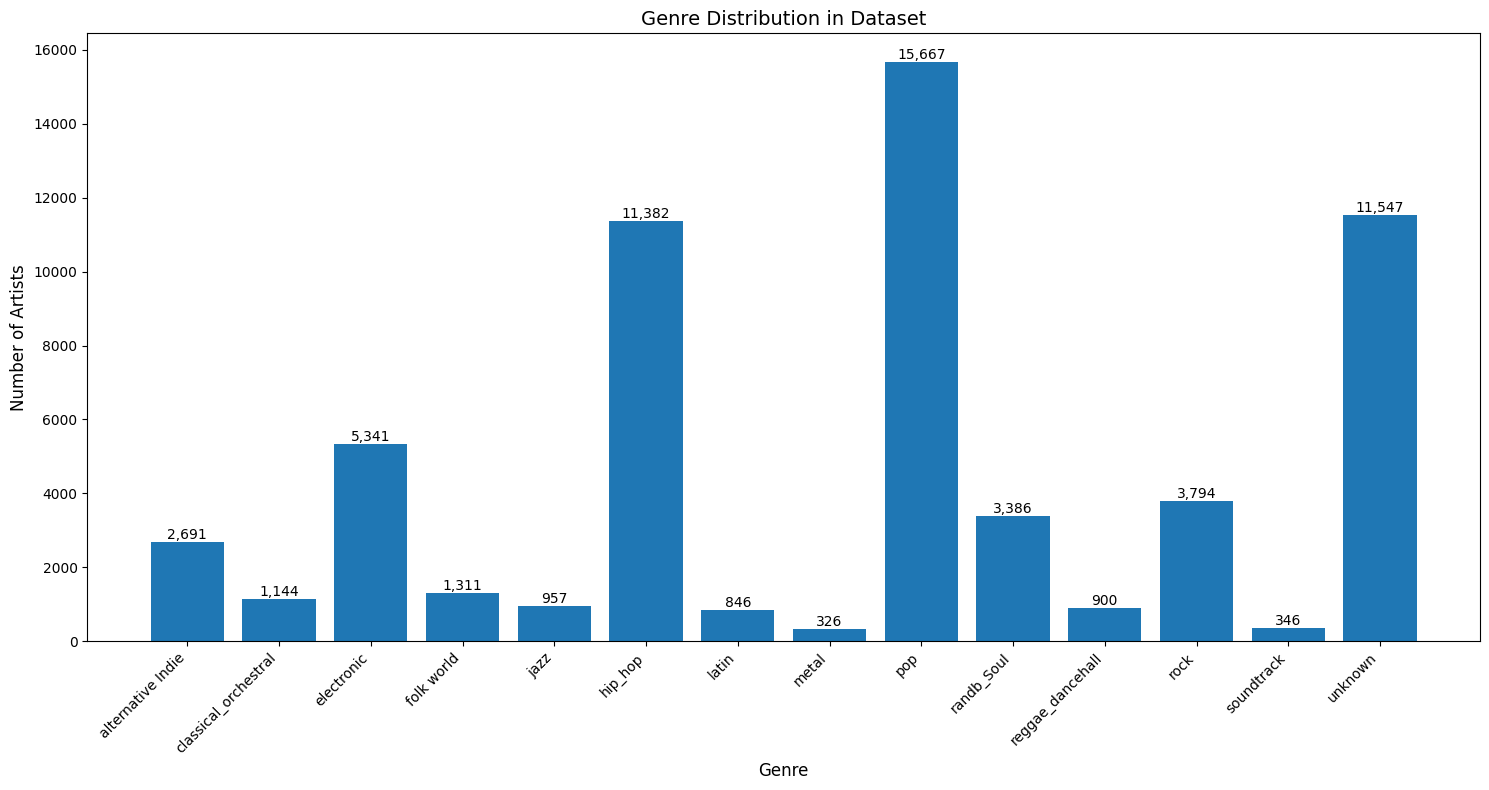

In [50]:

plot_genre_distribution(nodes_df, genre_columns)

# Preparing graph data...

In [51]:
print("\nPreparing graph data...")
data = prepare_bipartite_data(nodes_df, edges_df, genre_columns)

# Split edges for training
all_edges = data['artist', 'collaborates', 'artist'].edge_index.t()
train_edges, temp_edges = train_test_split(all_edges, test_size=0.3, random_state=42)
val_edges, test_edges = train_test_split(temp_edges, test_size=0.5, random_state=42)

model = HeterogeneousGNN(
    artist_features=2,      # followers, popularity
    genre_features=len(genre_columns),  # Use actual number of genres
    hidden_channels=64
).to(device)


Preparing graph data...

Preparing graph data on cpu
Created artist features tensor: torch.Size([96370, 2])
Created genre features tensor: torch.Size([14, 14])

Processing artist-genre relationships...


  1%|          | 708/96370 [00:00<00:13, 6891.64it/s]

Processed artist 0, genres: ['electronic', 'unknown']


 12%|█▏        | 11837/96370 [00:01<00:07, 12063.35it/s]

Processed artist 10000, genres: ['alternative Indie']


 44%|████▎     | 42099/96370 [00:04<00:05, 9812.10it/s]

Processed artist 40000, genres: ['reggae_dancehall']


100%|██████████| 96370/96370 [00:09<00:00, 10390.85it/s]



Created 59638 artist-genre edges

Genre edge indices created successfully

Valid collaboration edges: 186806

Final graph statistics:
Number of artists: 96370
Number of genres: 14
Number of artist-genre edges: 59638
Number of collaboration edges: 186806


# model training

In [52]:
print("\nTraining model...")
model, history = train_model(model, data, train_edges, val_edges)


Training model...
Training data size: torch.Size([130764, 2])
Validation data size: torch.Size([28021, 2])
Reshaped training edges: torch.Size([2, 130764])
Reshaped validation edges: torch.Size([2, 28021])
Using batch size: 128

Starting training:
Epoch | Batch | Train Loss | Train Acc | Val Loss | Val Acc | Val ROC-AUC
---------------------------------------------------------------------------


Epoch 1/2: 100%|██████████| 1022/1022 [1:12:48<00:00,  4.27s/it, loss=1.3932, acc=0.4539]


    1 |  1022 | 1.3903 | 0.4985 | 0.6928 | 0.5399 | 0.5318


Epoch 2/2: 100%|██████████| 1022/1022 [1:12:42<00:00,  4.27s/it, loss=1.3852, acc=0.4868]


    2 |  1022 | 1.3868 | 0.4995 | 0.6915 | 0.6128 | 0.6898

Training completed!
Best validation ROC-AUC: 0.6898417765950264

Final metrics:
Train Loss: 1.3868
Train Accuracy: 0.4995
Validation Loss: 0.6915
Validation Accuracy: 0.6128
Validation ROC-AUC: 0.6898


# Plot metrics

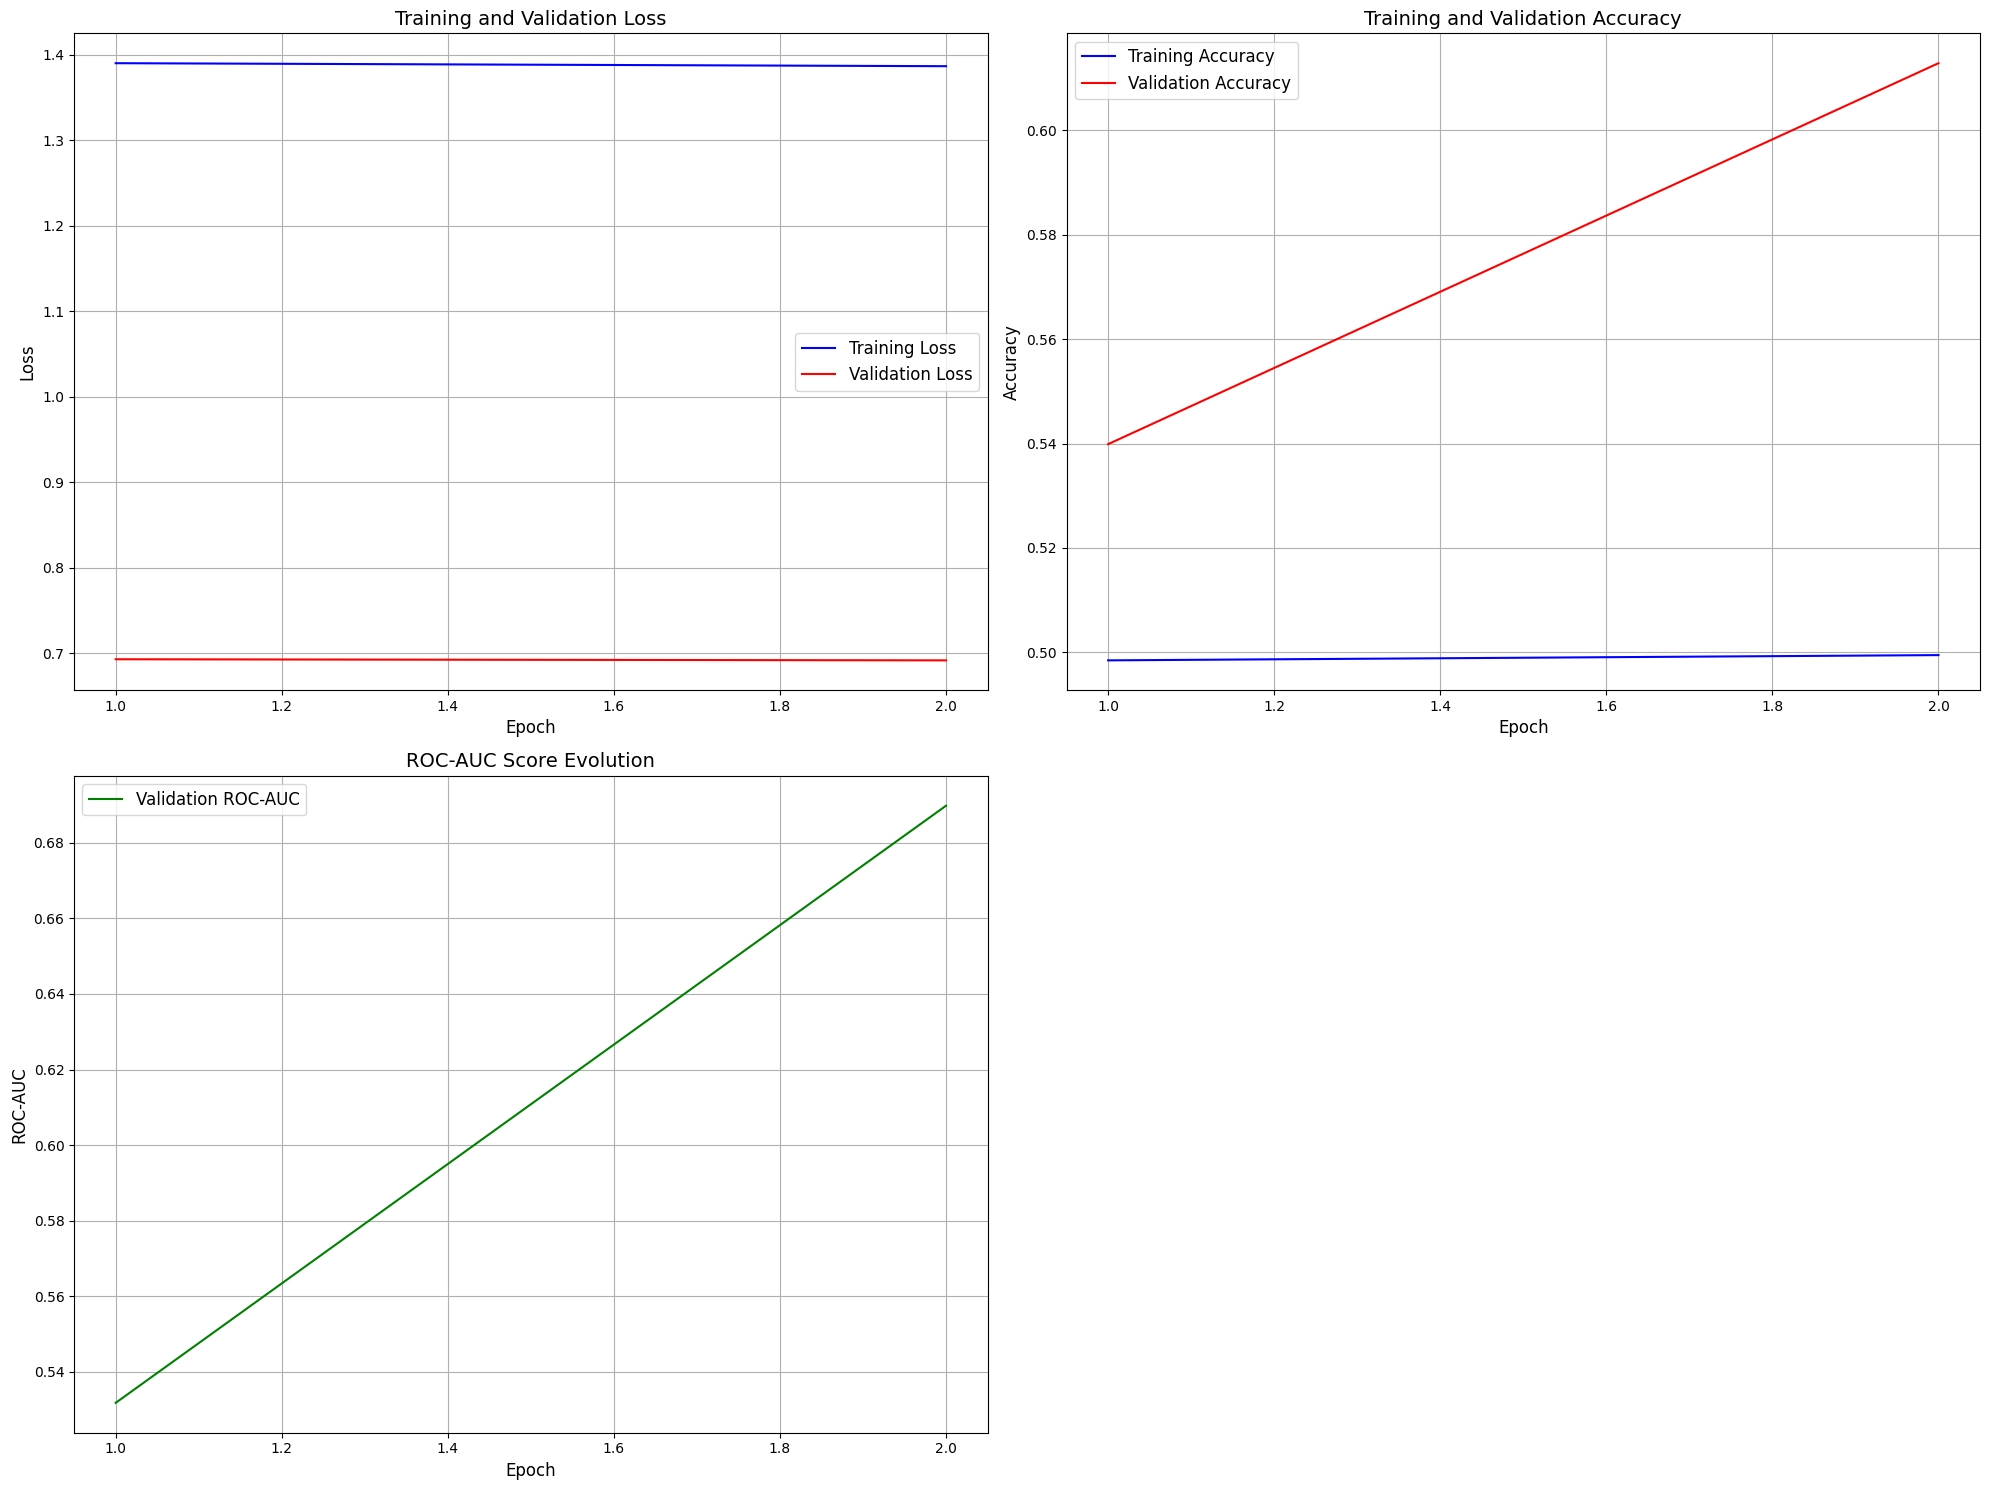

In [53]:
plot_training_metrics(history)

# Evaluate model and plot performance


Evaluating model performance...


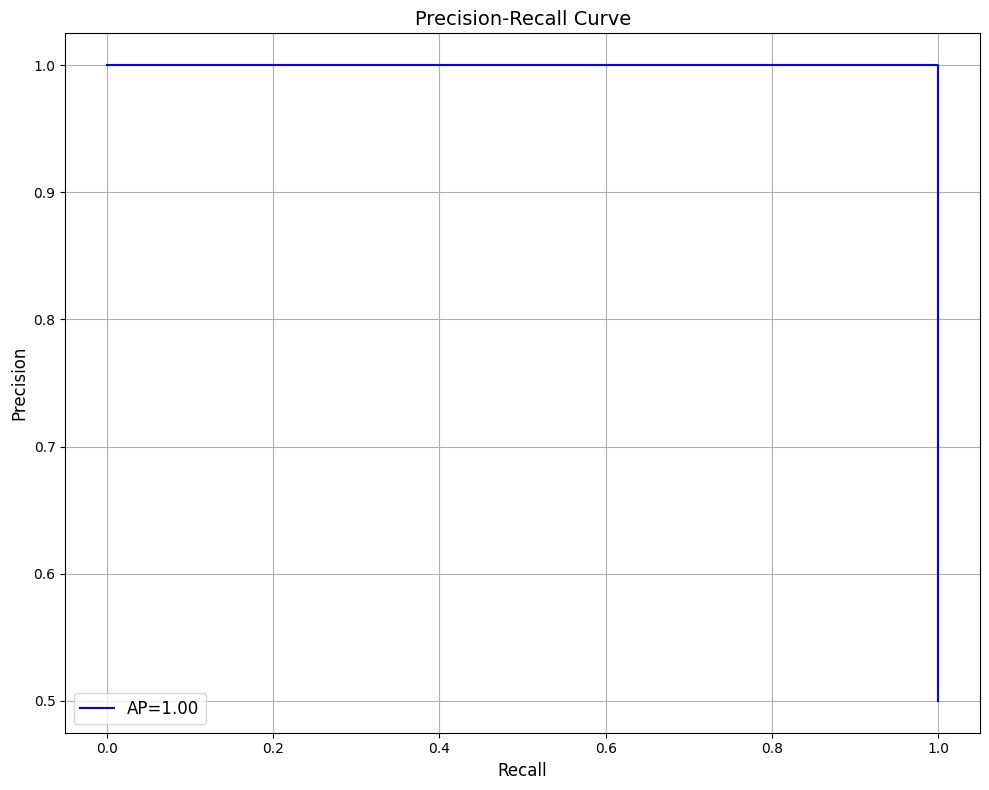

Test ROC-AUC: 1.0000
Test Average Precision: 1.0000
Test F1 Score: 0.8000


In [54]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score


print("\nEvaluating model performance...")
metrics = plot_model_performance(model, data, test_edges)

print(f"Test ROC-AUC: {metrics['roc_auc']:.4f}")
print(f"Test Average Precision: {metrics['average_precision']:.4f}")
print(f"Test F1 Score: {metrics['f1_score']:.4f}")

# Generate predictions

In [55]:
print("\nGenerating collaboration predictions...")
predictions = predict_new_collaborations(
    model,
    data,
    nodes_df,
    num_predictions=10,
    sample_size=5000,
    min_popularity=0.3
)


Generating collaboration predictions...
Computing embeddings...
Filtering artists by popularity...
Found 47119 artists above popularity threshold
Sampling potential pairs...


Sampling artist pairs: 100%|██████████| 5000/5000 [00:00<00:00, 7765.08it/s]


Processing 5000 potential pairs...


Computing scores: 100%|██████████| 10/10 [00:00<00:00, 1192.27it/s]


Finding top predictions...
Formatting predictions...
[{'artist1': 'Waka Flocka Flame', 'artist2': 'Michael Feiner', 'score': 0.5107060670852661, 'artist1_popularity': 2.3691293009145813, 'artist2_popularity': 0.3021658720975937, 'genres': []}]
[{'artist1': 'Waka Flocka Flame', 'artist2': 'Michael Feiner', 'score': 0.5107060670852661, 'artist1_popularity': 2.3691293009145813, 'artist2_popularity': 0.3021658720975937, 'genres': []}, {'artist1': 'Chris Stapleton', 'artist2': 'Polo G', 'score': 0.5089218616485596, 'artist1_popularity': 2.967460819782657, 'artist2_popularity': 3.348217240880523, 'genres': []}]
[{'artist1': 'Waka Flocka Flame', 'artist2': 'Michael Feiner', 'score': 0.5107060670852661, 'artist1_popularity': 2.3691293009145813, 'artist2_popularity': 0.3021658720975937, 'genres': []}, {'artist1': 'Chris Stapleton', 'artist2': 'Polo G', 'score': 0.5089218616485596, 'artist1_popularity': 2.967460819782657, 'artist2_popularity': 3.348217240880523, 'genres': []}, {'artist1': 'Baby 

# Save comprehensive results

In [56]:
results = save_training_summary(history, metrics, predictions)

print("\nResults have been saved to:")
print("1. training_metrics.png - Training progress visualization")
print("2. genre_distribution.png - Distribution of genres")
print("3. confusion_matrix.png - Model performance visualization")
print("4. precision_recall_curve.png - Model precision-recall curve")
print("5. results.json - Detailed results and predictions")
print("6. data_report.json - Data statistics and analysis")


Results have been saved to:
1. training_metrics.png - Training progress visualization
2. genre_distribution.png - Distribution of genres
3. confusion_matrix.png - Model performance visualization
4. precision_recall_curve.png - Model precision-recall curve
5. results.json - Detailed results and predictions
6. data_report.json - Data statistics and analysis


# Save results

In [57]:

results = {
    'model_performance': {
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'final_val_roc_auc': history['val_roc_auc'][-1]
    },
    'predictions': predictions
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults saved successfully!")


Results saved successfully!
